In [1]:
import os 
from pathlib import Path
import sys
import subprocess
import time
from typing import Optional
from collections import defaultdict 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

executables = ['genmc', 'genmc-wkmo', 'genmc-xmm']
arguments_dict = {
    'genmc' : ['--v0', '--disable-ipr', '--disable-sr', '--rc11'],
    'genmc-xmm' : ['--v0', '--disable-ipr', '--disable-sr', '--XMM'],
    'genmc-wkmo' : ['--count-duplicate-execs', '--wkmo'],
}
tests = sorted([Path('tests') / t / 'variants' / v for t in os.listdir('tests') if os.path.isdir(Path('tests') / t) for v in os.listdir(Path('tests') / t / 'variants')])
test_names = sorted([t for t in os.listdir('tests') if os.path.isdir(Path('tests') / t) for v in os.listdir(Path('tests') / t / 'variants')])
subprocess_timeout = 1 #s

class RunExecutableResult:
    class Timeout:
        pass
    class Ok:
        def __init__(self, output) -> None:
            super().__init__()
            self.output = output
    class Error:
        def __init__(self, retcode, output) -> None:
            super().__init__()
            self.retcode = retcode
            self.output = output

def run_executable(exe_path: Path, args: list[str], test_path: Path) -> RunExecutableResult:
    try:
        result = subprocess.run([exe_path, *args, test_path], stdout=subprocess.PIPE, stderr=subprocess.PIPE, timeout=subprocess_timeout)
        result_stdout = result.stdout.decode()
        result_stderr = result.stderr.decode()
        if result.returncode == 0:
            return RunExecutableResult.Ok(result_stdout + result_stderr)
        else:
            return RunExecutableResult.Error(result.returncode, result_stdout + result_stderr)
    except subprocess.TimeoutExpired:
        return RunExecutableResult.Timeout()

In [2]:
def get_number_executions(string: str) -> Optional[int]:
    pattern = "Number of complete executions explored: "
    i = string.index(pattern) + len(pattern)
    number_str = ""
    while i < len(string) and string[i].isdigit():
        number_str += string[i]
        i += 1
    try:
        return int(number_str)
    except:
        return None

assert(get_number_executions("abc 123 Number of complete executions explored: 123456") == 123456)

In [3]:
def run_and_get_number_execs(exe_path: Path, args: list[str], test_path: Path) -> RunExecutableResult:
    res = run_executable(exe_path, args, test_path)
    if isinstance(res, RunExecutableResult.Ok):
        execs = get_number_executions(res.output)
        if execs is None:
            print(f"could not get number of executions in {res.output}")
            return RunExecutableResult.Ok(0)
        else:
            return RunExecutableResult.Ok(execs)
    else:
        return res

In [4]:
results = defaultdict(lambda: [])
for exe in executables:
    for test in tests:
        execs = run_and_get_number_execs(Path("executables") / exe, arguments_dict[exe], test)
        assert(isinstance(execs, RunExecutableResult.Ok))
        results[exe].append(execs.output)

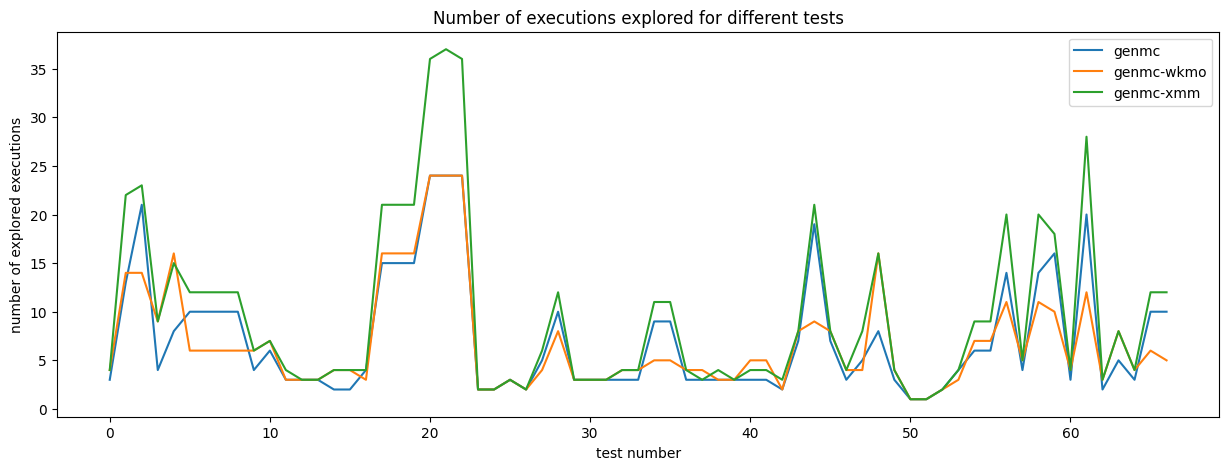

In [5]:
plt.figure(figsize=(15, 5))
for exe in results:
    plt.plot(results[exe])
plt.legend(executables)
plt.xlabel("test number")
plt.ylabel("number of explored executions")
plt.title("Number of executions explored for different tests")
plt.show()

In [6]:
# pd.set_option('display.max_rows', None)
df = pd.DataFrame(data=results)
df.index = tests
display(df.T)

,tests/LB/variants/lb0.c,tests/LB+CoRR/variants/lb+corr0.c,tests/LB+CoRRx/variants/lb+corrx0.c,tests/LB+LB/variants/lb+lb0.c,tests/LB+SB/variants/lb+sb0.c,tests/LB+W/variants/lb+w0.c,tests/LB+W/variants/lb+w1.c,tests/LB+W+data/variants/lb+w+data0.c,tests/LB+W+data/variants/lb+w+data1.c,tests/LB+Wd/variants/lb+wd0.c,...,tests/test2/variants/test0.c,tests/test20/variants/test0.c,tests/test3/variants/test0.c,tests/test4/variants/test0.c,tests/test5/variants/test0.c,tests/test6/variants/test0.c,tests/test7/variants/test0.c,tests/test8/variants/test0.c,tests/test9/variants/test0.c,tests/test9a/variants/test0.c
genmc,3,13,21,4,8,10,10,10,10,4,...,4,14,16,3,20,2,5,3,10,10
genmc-wkmo,4,14,14,9,16,6,6,6,6,6,...,5,11,10,4,12,3,8,4,6,5
genmc-xmm,4,22,23,9,15,12,12,12,12,6,...,5,20,18,4,28,3,8,4,12,12


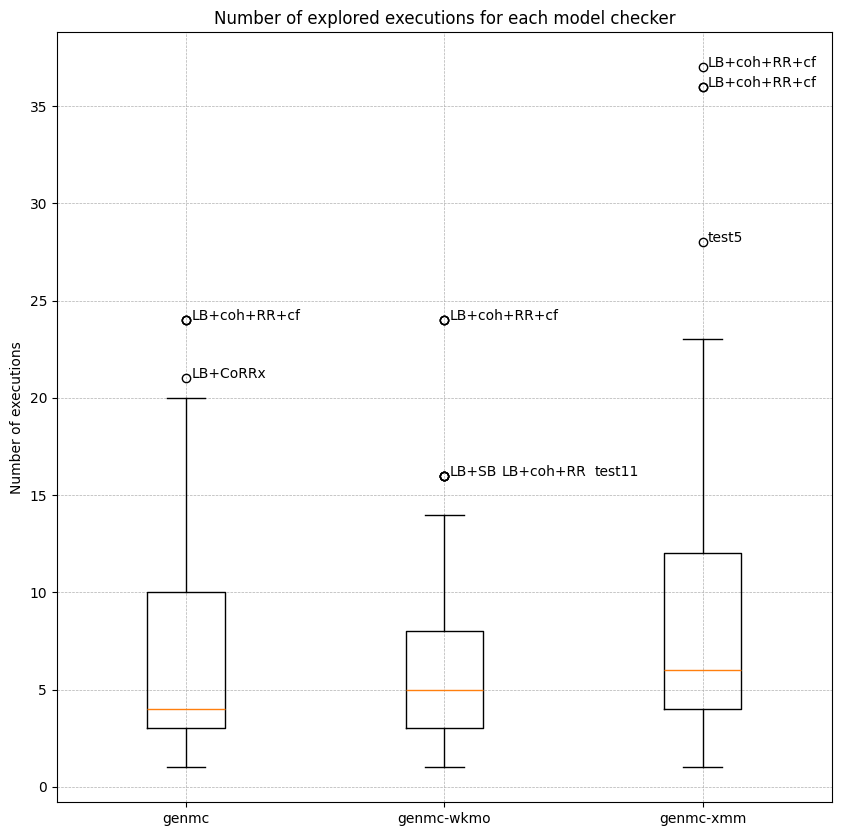

In [7]:
plt.figure(figsize=(10, 10))
# Plotting boxplots, we transpose the dataset so that each test variant becomes a separate category on the x-axis
boxplot = plt.boxplot(df.iloc[1:, :])
whiskers = [item.get_ydata()[1] for item in boxplot['whiskers']]
whiskers = list(zip(whiskers[::2], whiskers[1::2]))
plt.title('Number of explored executions for each model checker')
plt.ylabel('Number of executions')
plt.xticks([i + 1 for i in range(len(executables))], executables)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

for x, exe in enumerate(executables):
    vals = np.array(results[exe])
    vals_indices = np.arange(len(vals))

    lower_bound, upper_bound = whiskers[x]
    outlier_indices = vals_indices[(vals < lower_bound) | (vals > upper_bound)]

    mem = defaultdict(lambda: 0)
    mem_text = defaultdict(lambda: set())
    for i in outlier_indices:
        if test_names[i] in mem_text[vals[i]]:
            continue
        plt.text(x+1.02 + mem[vals[i]] * 0.04, vals[i], test_names[i])
        mem[vals[i]] += len(test_names[i])
        mem_text[vals[i]].add(test_names[i])

plt.show()
